# Modeling and Simulation in Python

Chapter 12

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code

Here's the code from the previous notebook that we'll need.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [7]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [8]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

In [10]:
def get_first_value(series):
    """Returns the first value of a series."""
    return series.iloc[0]

def get_last_value(series):
    """Returns the last value of a series."""
    return series.iloc[-1]


Here's an example.|

In [11]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.4672800628126752


**Exercise:** Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [18]:
def compute_peak_fraction(results):
    """Compute the fraction of students who are sick at the peak of the outbreak.

    results: TimeFrame with columns S, I, R

    returns: fraction of students who are sick at the peak
    """
    peak_index = results['I'].idxmax()
    peak_fraction = results.loc[peak_index, 'I']
    return peak_fraction


In [19]:
def compute_peak_day(results):
    """Compute the day the outbreak peaks.

    results: TimeFrame with columns S, I, R

    returns: day the outbreak peaks
    """
    peak_index = results['I'].idxmax()
    peak_day = peak_index + results.index[0]
    return peak_day


In [20]:
def compute_end_fraction(results):
    """Compute the fraction of students who are sick at the end of the semester.

    results: TimeFrame with columns S, I, R

    returns: fraction of students who are sick at the end
    """
    end_fraction = results.loc[results.index[-1], 'I']
    return end_fraction


### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [21]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [22]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

namespace(init=S    0.988889
               I    0.011111
               R    0.000000
               Name: state, dtype: float64,
          t0=0,
          t_end=98,
          beta=0.3333333333333333,
          gamma=0.25)

And run the model without immunization.

In [23]:
results = run_simulation(system, update_func)
calc_total_infected(results)

0.46843634512145604

Now with 10% immunization.

In [24]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

0.3067773759158855

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

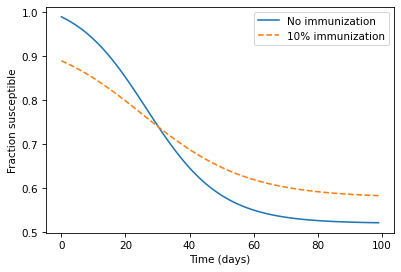

In [27]:
import matplotlib.pyplot as plt


plt.plot(results.S, '-', label='No immunization')
plt.plot(results2.S, '--', label='10% immunization')

plt.xlabel('Time (days)')
plt.ylabel('Fraction susceptible')
plt.legend()

plt.show()


Now we can sweep through a range of values for the fraction of the population who are immunized.

In [28]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.46843634512145604
0.1 0.3067773759158855
0.2 0.1615972308618978
0.30000000000000004 0.0728630987250175
0.4 0.03552346936020401
0.5 0.01968883914021219
0.6000000000000001 0.011622061266293171
0.7000000000000001 0.006838737865016542
0.8 0.003696496254630366
0.9 0.0014815326722739525
1.0 -0.00016121210941241054


This function does the same thing and stores the results in a `Sweep` object.

In [29]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [30]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

Parameter
0.00    0.468436
0.05    0.387480
0.10    0.306777
0.15    0.229529
0.20    0.161597
0.25    0.108916
0.30    0.072863
0.35    0.049952
0.40    0.035523
0.45    0.026122
0.50    0.019689
0.55    0.015072
0.60    0.011622
0.65    0.008956
0.70    0.006839
0.75    0.005119
0.80    0.003696
0.85    0.002500
0.90    0.001482
0.95    0.000603
1.00   -0.000161
Name: Metric, dtype: float64

And here's what the results look like.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


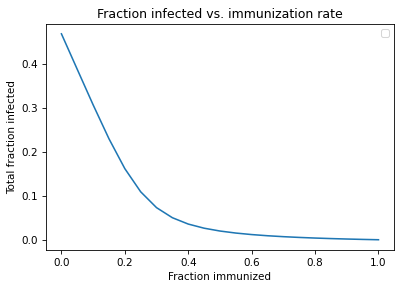

In [33]:
import matplotlib.pyplot as plt

plt.plot(infected_sweep)

plt.xlabel('Fraction immunized')
plt.ylabel('Total fraction infected')
plt.title('Fraction infected vs. immunization rate')
plt.legend()

plt.show()


If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [34]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [35]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [36]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


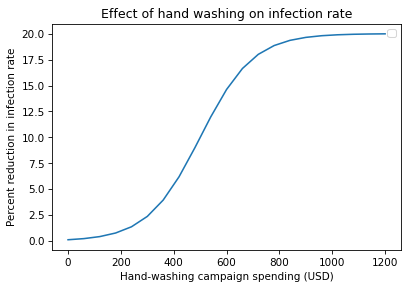

In [41]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt

percent_reduction = np.zeros(len(spending))

for i in range(len(spending)):
    percent_reduction[i] = compute_factor(spending[i]) * 100

plt.plot(spending, percent_reduction)
plt.xlabel('Hand-washing campaign spending (USD)')
plt.ylabel('Percent reduction in infection rate')
plt.title('Effect of hand washing on infection rate')
plt.legend()
plt.show()


**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [42]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [43]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [44]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

0.0 0.3328871432717143 0.4668879069012737
100.0 0.3321342526691939 0.4642630122501804
200.0 0.33017160845482885 0.4573484110691278
300.0 0.32538647186519215 0.44004577194139716
400.0 0.3154039052420003 0.40185777057153715
500.0 0.3 0.33738498288362895
600.0 0.28459609475799963 0.2677540099103801
700.0 0.2746135281348078 0.22227817314437215
800.0 0.26982839154517113 0.20119876208634124
900.0 0.2678657473308061 0.19278590144114072
1000.0 0.26711285672828566 0.18960127383137504
1100.0 0.26683150821044227 0.18841764004225225
1200.0 0.26672740341296003 0.18798057687227443


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [45]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [46]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

Parameter
0.000000       0.466888
63.157895      0.465537
126.315789     0.463029
189.473684     0.458420
252.631579     0.450122
315.789474     0.435705
378.947368     0.412167
442.105263     0.377458
505.263158     0.333529
568.421053     0.288054
631.578947     0.250187
694.736842     0.223962
757.894737     0.207897
821.052632     0.198710
884.210526     0.193639
947.368421     0.190891
1010.526316    0.189415
1073.684211    0.188625
1136.842105    0.188205
1200.000000    0.187981
Name: Metric, dtype: float64

And here's what it looks like.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


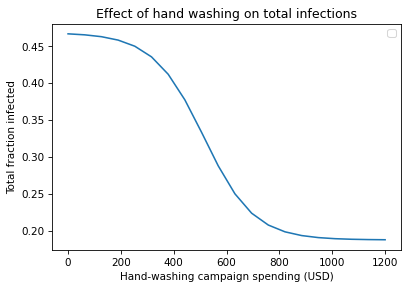

In [51]:
import matplotlib.pyplot as plt
plt.plot(infected_sweep)
plt.xlabel('Hand-washing campaign spending (USD)')
plt.ylabel('Total fraction infected')
plt.title('Effect of hand washing on total infections')
plt.legend()
plt.show()


Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [52]:
import numpy as np

num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.linspace(0, max_doses, max_doses + 1)
max_doses


12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [53]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

0.0 0.9888888888888889 0.26672740341296003 0.18798057687227443
1.0 0.9777777777777779 0.26683150821044227 0.1749332179598173
2.0 0.9666666666666667 0.26711285672828566 0.16323026892535375
3.0 0.9555555555555556 0.2678657473308061 0.15380081724382266
4.0 0.9444444444444445 0.26982839154517113 0.1488406716149695
5.0 0.9333333333333333 0.2746135281348078 0.15322837657945743
6.0 0.9222222222222223 0.28459609475799963 0.17528804249084784
7.0 0.9111111111111112 0.3 0.21770473418381664
8.0 0.9 0.3154039052420003 0.25941201224545773
9.0 0.888888888888889 0.32538647186519215 0.2787115299715025
10.0 0.8777777777777778 0.33017160845482885 0.2782106202567224
11.0 0.8666666666666667 0.3321342526691939 0.2676529400951123
12.0 0.8555555555555556 0.3328871432717143 0.25309423539892584


The following function wraps that loop and stores the results in a `Sweep` object.

In [54]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [55]:
infected_sweep = sweep_doses(dose_array)

Parameter
0     0.187981
1     0.174933
2     0.163230
3     0.153801
4     0.148841
5     0.153228
6     0.175288
7     0.217705
8     0.259412
9     0.278712
10    0.278211
11    0.267653
12    0.253094
Name: Metric, dtype: float64

And plot the results.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


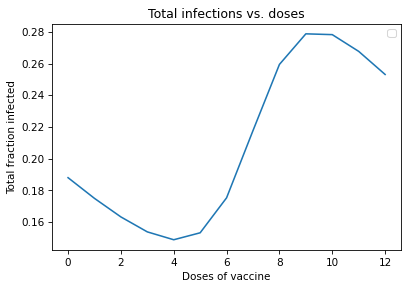

In [59]:
plt.plot(infected_sweep)
plt.xlabel('Doses of vaccine')
plt.ylabel('Total fraction infected')
plt.title('Total infections vs. doses')
plt.legend()
plt.show()


### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

In [ ]:
#Since we know more vaccinated and immunized folks there are, the less chances of a 
#health outbreak, this means that more doses can be purchased with the same budget,
# increasing population immunity.
#The next step would be to analyze the costs and benefits of each + dose.
#With the stated 'fact' above that the vaccine is 100% effected, there isnt much of a reason
#to not increase dose purchses, as long as hand washing add still are at their max impact.

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

In [63]:
def add_quarantine(system, fraction):

    low = 2
    high = 5
    beta = 1 / low      # contact rate in per day
    gamma = 1 / high
    # `low` is days a student is infectious if quarantined.
    # `high` is days they are infectious if not quarantined
    
    results = run_simulation(system, update_func)

    return results

system = make_system(beta, gamma)
results = add_quarantine(system, fraction)
calc_total_infected(results)


0.46843634512145604